In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
 

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
        'imgs/train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    'imgs/test',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical')


Found 1367 images belonging to 33 classes.
Found 325 images belonging to 33 classes.


In [5]:
# Load the pre-trained Xception model with ImageNet weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add some layers on top of the base model for classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(33, activation='softmax')(x)

# Create the final model to train
model = Model(inputs=base_model.input, outputs=predictions)

In [4]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoint path and directory
checkpoint_path = "./.ipynb_checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define the callbacks for early stopping and saving checkpoints
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_path,
                                verbose=1,
                                save_weights_only=True,
                                save_freq=2)
]

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

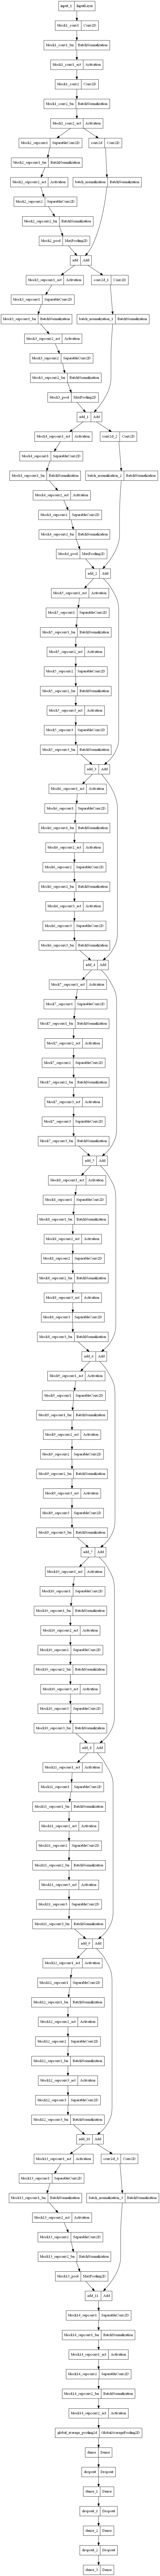

In [6]:
tf.keras.utils.plot_model(model)

In [8]:
# Train the model
history = model.fit(train_generator,
                              epochs=20,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              verbose=1)


Epoch 1/20
 1/43 [..............................] - ETA: 6:23 - loss: 0.1851 - accuracy: 0.8750
Epoch 1: saving model to .\.ipynb_checkpoints
 3/43 [=>............................] - ETA: 4:11 - loss: 0.1858 - accuracy: 0.9167
Epoch 1: saving model to .\.ipynb_checkpoints
 5/43 [==>...........................] - ETA: 3:56 - loss: 0.1574 - accuracy: 0.9250
Epoch 1: saving model to .\.ipynb_checkpoints
 7/43 [===>..........................] - ETA: 3:47 - loss: 0.1737 - accuracy: 0.9152
Epoch 1: saving model to .\.ipynb_checkpoints
 9/43 [=====>........................] - ETA: 3:37 - loss: 0.1840 - accuracy: 0.9167
Epoch 1: saving model to .\.ipynb_checkpoints
11/43 [======>.......................] - ETA: 3:24 - loss: 0.1788 - accuracy: 0.9205
Epoch 1: saving model to .\.ipynb_checkpoints
13/43 [========>.....................] - ETA: 3:11 - loss: 0.1661 - accuracy: 0.9279
Epoch 1: saving model to .\.ipynb_checkpoints
15/43 [=========>....................] - ETA: 2:58 - loss: 0.1774 - accu

30/43 [===================>..........] - ETA: 51s - loss: 0.2163 - accuracy: 0.9167
Epoch 6: saving model to .\.ipynb_checkpoints
32/43 [=====================>........] - ETA: 43s - loss: 0.2170 - accuracy: 0.9150
Epoch 6: saving model to .\.ipynb_checkpoints
34/43 [======================>.......] - ETA: 35s - loss: 0.2161 - accuracy: 0.9145
Epoch 6: saving model to .\.ipynb_checkpoints
36/43 [========================>.....] - ETA: 27s - loss: 0.2184 - accuracy: 0.9141
Epoch 6: saving model to .\.ipynb_checkpoints
38/43 [=========================>....] - ETA: 19s - loss: 0.2134 - accuracy: 0.9155
Epoch 6: saving model to .\.ipynb_checkpoints
40/43 [==========================>...] - ETA: 11s - loss: 0.2134 - accuracy: 0.9135
Epoch 6: saving model to .\.ipynb_checkpoints
42/43 [============================>.] - ETA: 3s - loss: 0.2069 - accuracy: 0.9169
Epoch 6: saving model to .\.ipynb_checkpoints
43/43 [==============================] - 206s 5s/step - loss: 0.2053 - accuracy: 0.9181 - v

In [9]:
model_json = model.to_json()
with open("xcemption_model.json",'w')as json_file:
    json_file.write(model_json)
    
#saving trained model weight
model.save_weights('xcemption_model.h5')

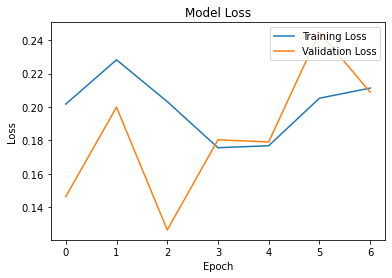

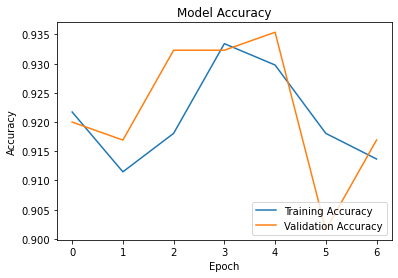

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [ ]:
# 2nd model

In [6]:
model1 = Sequential() 
model1.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(256,256,3))) 
model1.add(Activation('relu')) 
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
model1.add(Conv2D(64, (5, 5))) 
model1.add(Activation('relu')) 
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(Dropout(0.7)) 
model1.add(Flatten()) 
model1.add(Dense(1000)) 
model1.add(Activation('relu')) 
model1.add(Dropout(0.7)) 
model1.add(Dense(33, activation='softmax')) 
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 activation (Activation)     (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 64)      51264     
                                                                 
 activation_1 (Activation)   (None, 122, 122, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                    

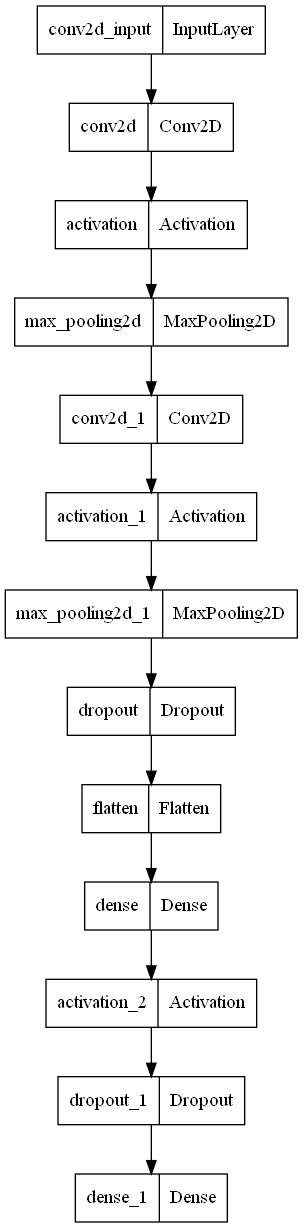

In [5]:
tf.keras.utils.plot_model(model1)

In [8]:
imagenet_model_file = "imagenet.h5" 
best_model = ModelCheckpoint(imagenet_model_file, monitor='val_loss', verbose=1, save_best_only=True) 
print('Training model...') 
results = model1.fit(train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=[best_model],
                              verbose=1) 


Training model...
Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 3.7441 - accuracy: 0.0549
Epoch 1: val_loss improved from inf to 3.23111, saving model to imagenet.h5
43/43 [==============================] - 334s 8s/step - loss: 3.7441 - accuracy: 0.0549 - val_loss: 3.2311 - val_accuracy: 0.1446
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 3.1850 - accuracy: 0.1170
Epoch 2: val_loss improved from 3.23111 to 2.63429, saving model to imagenet.h5
43/43 [==============================] - 355s 8s/step - loss: 3.1850 - accuracy: 0.1170 - val_loss: 2.6343 - val_accuracy: 0.2246
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 2.8814 - accuracy: 0.1544
Epoch 3: val_loss improved from 2.63429 to 2.39140, saving model to imagenet.h5
43/43 [==============================] - 323s 8s/step - loss: 2.8814 - accuracy: 0.1544 - val_loss: 2.3914 - val_accuracy: 0.3785
Epoch 4/100
43/43 [==============================] - ETA: 0s - loss: 2.

Epoch 58/100
43/43 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.7527
Epoch 58: val_loss did not improve from 0.37814
43/43 [==============================] - 165s 4s/step - loss: 0.7506 - accuracy: 0.7527 - val_loss: 0.4034 - val_accuracy: 0.8738
Epoch 59/100
43/43 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7535
Epoch 59: val_loss did not improve from 0.37814
43/43 [==============================] - 166s 4s/step - loss: 0.7090 - accuracy: 0.7535 - val_loss: 0.4412 - val_accuracy: 0.8615
Epoch 60/100
43/43 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.7564
Epoch 60: val_loss did not improve from 0.37814
43/43 [==============================] - 166s 4s/step - loss: 0.7545 - accuracy: 0.7564 - val_loss: 0.4165 - val_accuracy: 0.8677
Epoch 61/100
43/43 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7754
Epoch 61: val_loss did not improve from 0.37814
43/43 [===========================

43/43 [==============================] - 180s 4s/step - loss: 0.5218 - accuracy: 0.8091 - val_loss: 0.2576 - val_accuracy: 0.9169
Epoch 88/100
43/43 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.8047
Epoch 88: val_loss did not improve from 0.25758
43/43 [==============================] - 168s 4s/step - loss: 0.5456 - accuracy: 0.8047 - val_loss: 0.3226 - val_accuracy: 0.8862
Epoch 89/100
43/43 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8105
Epoch 89: val_loss did not improve from 0.25758
43/43 [==============================] - 168s 4s/step - loss: 0.5282 - accuracy: 0.8105 - val_loss: 0.4477 - val_accuracy: 0.8462
Epoch 90/100
43/43 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7988
Epoch 90: val_loss improved from 0.25758 to 0.24297, saving model to imagenet.h5
43/43 [==============================] - 180s 4s/step - loss: 0.5542 - accuracy: 0.7988 - val_loss: 0.2430 - val_accuracy: 0.9108
Epoch 91/100
43

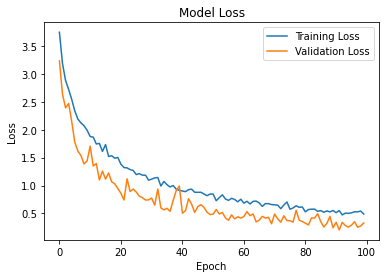

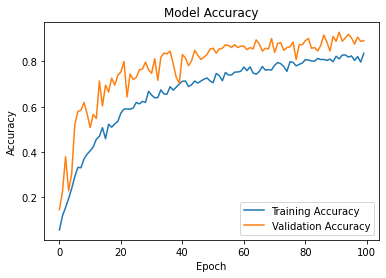

In [9]:
import matplotlib.pyplot as plt
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Plot the training accuracy and validation accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [7]:
from tensorflow.keras.layers import Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

In [8]:
output1 = model.layers[-2].output  # output before the flatten layer
output2 = model1.layers[-2].output  # output before the flatten layer


In [9]:
merged = Concatenate()([output1, output2])

In [10]:
merged = Dense(128, activation='relu')(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dense(10, activation='softmax')(merged)


In [11]:
new_model = Model(inputs=[model.input, model1.input], outputs=merged)


In [12]:
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

 max_pooling2d_1 (MaxPooling2D)  (None, 61, 61, 64)  0           ['activation_1[0][0]']           
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 dropout_3 (Dropout)            (None, 61, 61, 64)   0           ['max_pooling2d_1[0][0]']        
                                                                                                  
 dense_1 (Dense)                (None, 512)          524800      ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 238144)       0           ['dropout_3[0][0]']              
                                                                                                  
 dropout_1

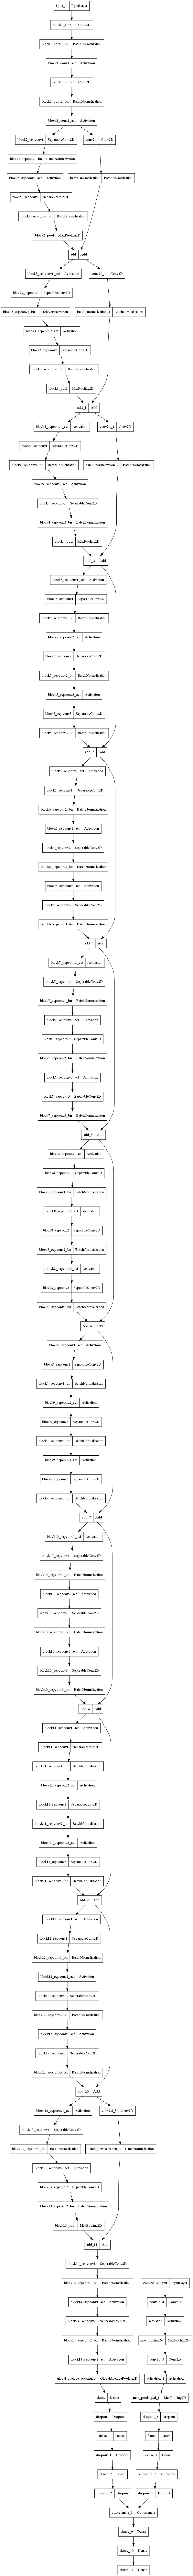

In [55]:
tf.keras.utils.plot_model(new_model)

In [56]:
model_json = new_model.to_json()
with open("Concatenated_model.json",'w')as json_file:
    json_file.write(model_json)
    
#saving trained model weight
new_model.save_weights('Concatenated_model.h5')

1/1 [==============================] - 0s 173ms/step
Predicted Class: Ford Woodlotus, Probability: 0.5551


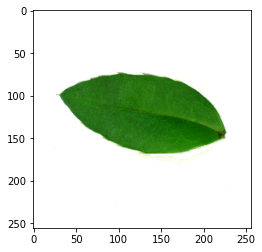

In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Replace 'image_path' with the path to your single image
image_path = "standardleaves\\3.jpg"

# Load the image
img = image.load_img(image_path, target_size=(256, 256))
plt.imshow(img)

img = image.img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)



# Make predictions for the single image
preds1 = model.predict(img)
preds2 = model1.predict(img)


# # taking average of both models
merged = np.vstack((preds1, preds2))

ensemble_preds = np.mean([preds1,preds2], axis=0)

# Define a dictionary to map class indices to class names starting from index 1
class_labels = {
    0: 'pubescent bamboo',
    1: 'Chinese horse chestnut',
    2: 'Anhui Barberry',
    3: 'Chinese redbud',
    4: 'true indigo',
    5: 'Japanese maple',
    6: 'Nanmu',
    7: 'castor aralia',
    8: 'Chinese cinnamon',
    9: 'goldenrain tree',
    10: 'Big-fruited Holly',
    11: 'Japanese cheesewood',
    12: 'wintersweet',
    13: 'camphortree',
    14: 'Japan Arrowwood',
    15: 'sweet osmanthus',
    16: 'deodar',
    17: 'ginkgo',
    18: 'maidenhair tree',
    19: 'Crape myrtle,Crepe myrtle',
    20: 'oleander',
    21: 'yew plum pine',
    22: 'Japanese Flowering Cherry',
    23: 'Glossy Privet',
    24: 'Chinese Toon',
    25: 'peach',
    26: 'Ford Woodlotus',
    27: 'trident maple',
    28: 'Beales barberry',
    29: 'southern magnolia',
    30: 'Canadian poplar',
    31: 'Chinese tulip tree',
    32: 'tangerine',
   
}

# Convert the predicted class index to match the dictionary
predicted_class_index = np.argmax(merged, axis=1)[0] 
predicted_class = class_labels[predicted_class_index]
probability = merged[0][predicted_class_index]

print(f"Predicted Class: {predicted_class}, Probability: {probability:.4f}")


In [2]:
# print(merged)
# print('/n')
# print(ensemble_preds)